# Transformer Emulator/Operator in JAX

A showcase for training a transformer emulator/operator $f_\theta$ in JAX to
emulate the timestepping operator $\mathcal{P}_h$ associated with the advection
PDE

$$
\partial_t u + c \partial_x u = 0
$$

on a one-dimensional periodic domain. We will train, test and compare the
performance with other emulators by using
[APEBench](https://github.com/tum-pbs/apebench).

For this, we will implement a **decoder-only** transformer architecture
following the design of the [Attention is All You Need (Vaswani et al.,
2017)](https://arxiv.org/abs/1706.03762) paper in
[JAX](https://github.com/google/jax) using the
[Equinox](https://github.com/patrick-kidger/equinox) deep learning framework.

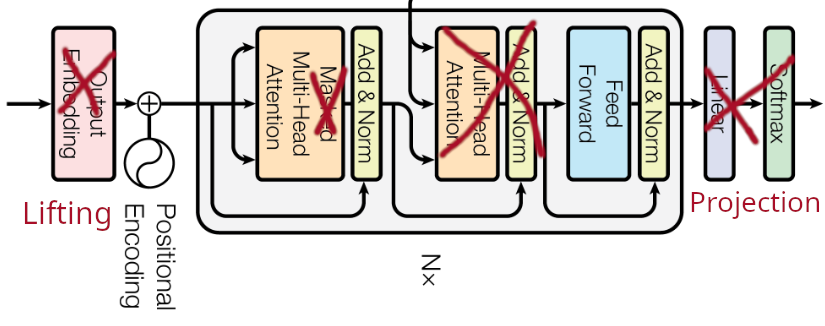

The decoder-only architecture requires the following components:

1. The scaled dot-product attention mechanism
2. A multi-head attention layer
3. A transformer block consisting of a multi-head attention layer and a
   feed-forward network (which we will then stack to form the complete
   transformer)
4. Positional encoding because a vanilla transformer is permutation invariant
5. An interface between the physics layout and the transformer's sequence layout

Note that we will **not use causal masking** because we want to attend over the
entire space (i.e., over the spatial degrees of freedom) and not over time
(i.e., over the timesteps). The emulator behaves autoregressively in time.

This examples makes heavy usage of the `jax.vmap` to simplify the implementation
and keep it close to the mathematical description.

In [1]:
%pip install equinox apebench

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.4 MB/s eta 0:00:00


In [27]:
from typing import Callable

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, PRNGKeyArray
import json
import apebench
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
advection_scenario = apebench.scenarios.difficulty.Advection()

In [4]:
train_data = advection_scenario.get_train_data()
train_data.shape

(50, 51, 1, 160)

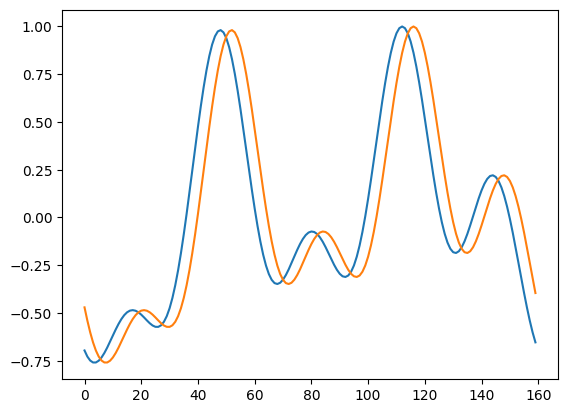

In [5]:
plt.plot(train_data[2, :2, 0, :].T)

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [6]:
def scaled_dot_product_attention(
    query: Float[Array, "seq_len key_size"],
    key: Float[Array, "seq_len key_size"],
    value: Float[Array, "seq_len value_size"],
) -> Float[Array, "seq_len value_size"]:
    """No masking"""
    key_size = query.shape[-1]
    attn_logits: Float[Array, "seq_len seq_len"] = (query @ key.T) / jnp.sqrt(key_size)
    attn_weights: Float[Array, "seq_len seq_len"] = jax.nn.softmax(attn_logits, axis=-1)
    results: Float[Array, "seq_len value_size"] = attn_weights @ value
    return results

$$\begin{split}\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(XW_i^Q,XW_i^K, XW_i^V)
\end{split}\end{split}$$

In [7]:
class MultiheadAttention(eqx.Module):
    num_heads: int
    query_proj: eqx.nn.Linear
    key_proj: eqx.nn.Linear
    value_proj: eqx.nn.Linear
    output_proj: eqx.nn.Linear


    def __init__(
        self,
        num_heads: int,
        num_channels: int,
        *,
        key: PRNGKeyArray,
    ):
        (
            query_proj_key,
            key_proj_key,
            value_proj_key,
            output_proj_key
        ) = jax.random.split(key, 4)

        self.query_proj = eqx.nn.Linear(
            num_channels,
            num_channels,
            use_bias=False,
            key=query_proj_key,
        )
        self.key_proj = eqx.nn.Linear(
            num_channels,
            num_channels,
            use_bias=False,
            key=key_proj_key,
        )
        self.value_proj = eqx.nn.Linear(
            num_channels,
            num_channels,
            use_bias=False,
            key=value_proj_key,
        )
        self.output_proj = eqx.nn.Linear(
            num_channels,
            num_channels,
            use_bias=False,
            key=output_proj_key,
        )

        self.num_heads = num_heads

    def __call__(
        self,
        x: Float[Array, "seq_len channels"],
    ) -> Float[Array, "seq_len channels"]:
        seq_len, channels = x.shape

        # Needs to vectorize over the sequence length
        query: Float[Array, "seq_len query_size"] = jax.vmap(self.query_proj)(x)
        key = jax.vmap(self.key_proj)(x)
        value = jax.vmap(self.value_proj)(x)

        # Reshape to split the heads
        query: Float[Array, "seq_len num_heads query_size//num_heads"] =\
            query.reshape((seq_len, self.num_heads, channels//self.num_heads))
        key = key.reshape((seq_len, self.num_heads, channels//self.num_heads))
        value = value.reshape((seq_len, self.num_heads, channels//self.num_heads))

        # Compute attention while vectorizing over the heads
        results = jax.vmap(
            scaled_dot_product_attention,
            in_axes=-2,
            out_axes=-2
        )(query, key, value)

        # Concatenate the heads
        results = results.reshape((seq_len, channels))

        # Project the output, vectorizing over the sequence length
        out = jax.vmap(self.output_proj)(results)

        return out

In [8]:
class TransformerBlock(eqx.Module):
    mha: MultiheadAttention
    mlp: eqx.nn.MLP
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm

    def __init__(
        self,
        num_heads: int,
        channels: int,
        mlp_channels_multiplier: int = 2,
        activation: Callable = jax.nn.relu,
        *,
        key: PRNGKeyArray
    ):
        mha_key, mlp_key = jax.random.split(key, 2)
        self.mha = MultiheadAttention(
            num_heads,
            channels,
            key=mha_key,
        )
        self.mlp = eqx.nn.MLP(
            in_size=channels,
            out_size=channels,
            width_size=mlp_channels_multiplier*channels,
            depth=1,
            activation=activation,
            use_bias=False,
            use_final_bias=False,
            key=mlp_key,
        )
        self.norm1 = eqx.nn.LayerNorm(channels)
        self.norm2 = eqx.nn.LayerNorm(channels)


    def __call__(
        self,
        x: Float[Array, "seq_len channels"],
    ) -> Float[Array, "seq_len channels"]:
        x = jax.vmap(self.norm1)(self.mha(x) + x)
        x = jax.vmap(self.norm2)(jax.vmap(self.mlp)(x) + x)
        return x

$$
\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}
$$

In [9]:
def build_positional_encoding_table(
    max_len: int,
    num_channels: int,
    base: int = 10_000,
) -> Float[Array, "max_len num_channels"]:
    pe = jnp.zeros((max_len, num_channels))

    position: Int[Array, "max_len 1"] = jnp.arange(0, max_len)[:, None]
    channel: Int[Array, "1 num_channels"] = jnp.arange(0, num_channels)[None, :]

    even_channel: Int[Array, "1 num_channels/2"] = channel[:, 0::2]

    frequency_scaling: Float[Array, "1 num_channels/2"] =\
        base**(even_channel/num_channels)

    pe_even_channels: Float[Array, "max_len num_channels/2"] =\
        jnp.sin(position/frequency_scaling)
    pe_odd_channels: Float[Array, "max_len num_channels/2"] =\
        jnp.cos(position/frequency_scaling)

    pe = pe.at[:, 0::2].set(pe_even_channels)
    pe = pe.at[:, 1::2].set(pe_odd_channels)

    return pe

Text(0, 0.5, 'Channel')

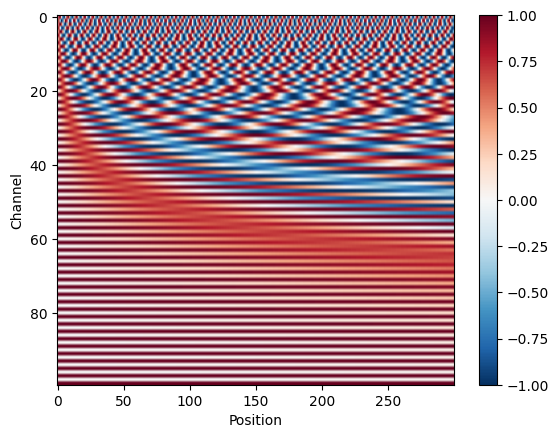

In [10]:
plt.imshow(
    build_positional_encoding_table(300, 100).T,
    cmap="RdBu_r",
    aspect="auto",
)
plt.colorbar()
plt.xlabel("Position")
plt.ylabel("Channel")

In [11]:
class PositionalEncoding(eqx.Module):
    encoding_table: Float[Array, "max_len channels"]

    def __init__(
        self,
        max_len: int,
        channels: int,
    ):
        self.encoding_table = build_positional_encoding_table(max_len, channels)

    def __call__(
        self,
        x: Float[Array, "seq_len channels"],
    ) -> Float[Array, "seq_len channels"]:
        seq_len = x.shape[0]
        encoding_info = self.encoding_table[:seq_len, :]
        # Avoids backpropagating through the encoding table, it should not be
        # trainable
        encoding_info = jax.lax.stop_gradient(encoding_info)

        return x + encoding_info

In [12]:
class Transformer(eqx.Module):
    blocks: list[TransformerBlock]
    pos_enc: PositionalEncoding

    def __init__(
        self,
        num_heads: int,
        channels: int,
        num_blocks: int,
        mlp_channels_multiplier: int = 2,
        activation: Callable = jax.nn.relu,
        max_length: int = 256, # maximum length of the sequence
        *,
        key: PRNGKeyArray
    ):
        blocks = []
        for i in range(num_blocks):
            block_key = jax.random.fold_in(key, i)
            blocks.append(
                TransformerBlock(
                    num_heads=num_heads,
                    channels=channels,
                    mlp_channels_multiplier=mlp_channels_multiplier,
                    activation=activation,
                    key=block_key,
                )
            )
        self.blocks = blocks
        self.pos_enc = PositionalEncoding(max_length, channels)

    def __call__(
        self,
        x: Float[Array, "seq_len channels"],
    ) -> Float[Array, "seq_len channels"]:
        x = self.pos_enc(x)
        for block in self.blocks:
            x = block(x)
        return x

In [13]:
class TransformerEmulator1d(eqx.Module):
    lifting: eqx.nn.MLP
    transformer: Transformer
    projection: eqx.nn.MLP

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        num_heads: int,
        num_blocks: int,
        mlp_channels_multiplier: int = 2,
        activation: Callable = jax.nn.relu,
        max_length: int = 256, # maximum length of the sequence
        *,
        key: PRNGKeyArray
    ):
        lifting_key, transformer_key, projection_key = jax.random.split(key, 3)

        self.lifting = eqx.nn.MLP(
            in_size=in_channels,
            out_size=hidden_channels,
            width_size=hidden_channels,
            depth=2,  # two hidden layers
            activation=activation,
            use_bias=True,
            use_final_bias=True,
            key=lifting_key,
        )
        self.transformer = Transformer(
            num_heads=num_heads,
            channels=hidden_channels,
            num_blocks=num_blocks,
            mlp_channels_multiplier=mlp_channels_multiplier,
            activation=activation,
            max_length=max_length,
            key=transformer_key,
        )
        self.projection = eqx.nn.MLP(
            in_size=hidden_channels,
            out_size=out_channels,
            width_size=hidden_channels,
            depth=2,  # two hidden layers
            activation=activation,
            use_bias=True,
            use_final_bias=True,
            key=projection_key,
        )

    def __call__(
        self,
        x: Float[Array, "in_channels num_points"],
    ) -> Float[Array, "out_channels num_points"]:
        # Transpose to [num_points in_channels]: num_points is then considered
        # the seq_len
        x = x.T

        # Vectorize over the sequence length (i.e., the num_points)
        x = jax.vmap(self.lifting)(x)

        x = self.transformer(x)

        x = jax.vmap(self.projection)(x)

        # Transpose back into the input format
        return x.T

In [16]:
dummy_emulator = TransformerEmulator1d(
    1,
    1,
    64,
    4,
    4,
    key=jax.random.key(42),
)

In [17]:
apebench.pdequinox.count_parameters(dummy_emulator)

165313

In [18]:
def transformer_constructor(
    config: str,
    num_spatial_dims: int,
    num_points: int,
    num_channels: int,
    activation_fn,
    key,
):
    if num_spatial_dims != 1:
        raise ValueError("Only 1D supported")
    args = config.split(";")
    hidden_channels = int(args[1])
    num_heads = int(args[2])
    num_blocks = int(args[3])
    max_length = num_points
    return TransformerEmulator1d(
        in_channels=num_channels,
        out_channels=num_channels,
        hidden_channels=hidden_channels,
        num_heads=num_heads,
        num_blocks=num_blocks,
        activation=activation_fn,
        max_length=max_length,
        key=key,
    )


apebench.components.architecture_dict["trans"] = transformer_constructor

In [19]:
CONFIGS = [
    {
        "scenario": "diff_adv",
        "net": net,
        "task": "predict",
        "train": "one",
        "start_seed": 0,
        "num_seeds": 5,
    }
    for net in [
        "Trans;64;4;4;relu",
        "Conv;34;10;relu",
    ]
]

In [20]:
metric_df, loss_df, sample_rollout_df, _ = apebench.run_study_convenience(
    CONFIGS,
    base_path="results/",
    do_loss=True,
    do_sample_rollouts=True,
)

Considering
diff_adv__predict__Trans;64;4;4;relu__one__0-4


E: 00000, B: 00000:   0%|          | 0/10000 [00:00<?, ?it/s]

Finished training!

Considering
diff_adv__predict__Conv;34;10;relu__one__0-4


E: 00000, B: 00000:   0%|          | 0/10000 [00:00<?, ?it/s]

Finished training!



Melt and Concat metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Melt and Concat loss:   0%|          | 0/2 [00:00<?, ?it/s]

Melt and Concat sample rollouts:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
loss_df

seed     scenario     task                net train scenario_kwargs  \
0       0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
1       0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
2       0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
3       0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
4       0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
..    ...          ...      ...                ...   ...             ...   
995     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
996     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
997     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
998     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
999     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   

     update_step  train_loss  
0              0    0.216064  
1            100    0.207846  
2            200    0.052517  
3            300    0.056354  
4            400    0.051140  
..           ...         ...  
995         9500    0.000002  
996         9600    0.000002  
997         9700    0.000002  
998         9800    0.000002  
999         9900    0.000002  

[1000 rows x 8 columns]

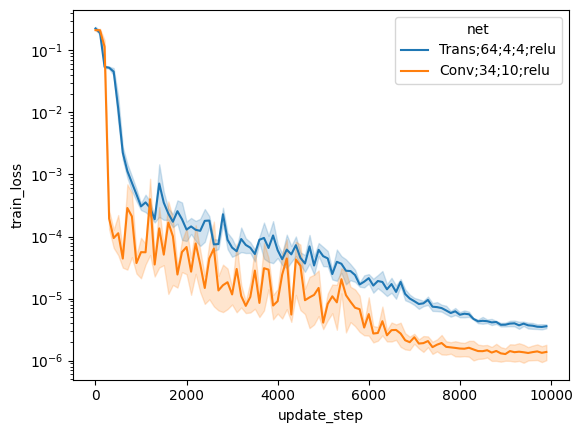

In [22]:
sns.lineplot(loss_df, x="update_step", y="train_loss", hue="net")
plt.yscale("log")

In [23]:
metric_df

seed     scenario     task                net train scenario_kwargs  \
0        0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
1        0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
2        0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
3        0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
4        0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
...    ...          ...      ...                ...   ...             ...   
1995     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
1996     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
1997     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
1998     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
1999     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   

      time_step  mean_nRMSE  
0             1    0.004161  
1             2    0.006204  
2             3    0.007605  
3             4    0.008879  
4             5    0.009969  
...         ...         ...  
1995        196    0.490226  
1996        197    0.492569  
1997        198    0.494906  
1998        199    0.497236  
1999        200    0.499564  

[2000 rows x 8 columns]

<Axes: xlabel='time_step', ylabel='mean_nRMSE'>

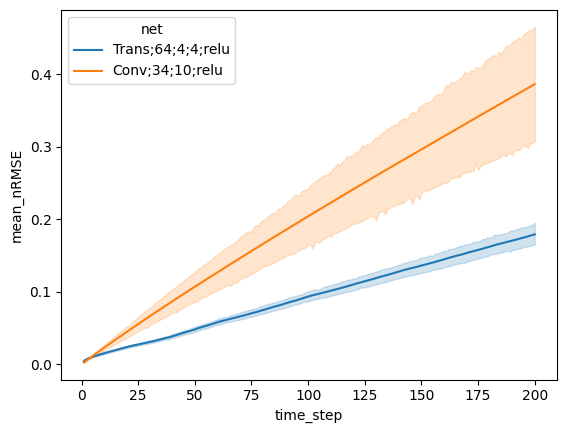

In [24]:
sns.lineplot(metric_df, x="time_step", y="mean_nRMSE", hue="net")

In [26]:
sample_rollout_df

seed     scenario     task                net train scenario_kwargs  \
0     0  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
1     1  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
2     2  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
3     3  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
4     4  1d_diff_adv  predict  Trans;64;4;4;relu   one              {}   
5     0  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
6     1  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
7     2  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
8     3  1d_diff_adv  predict    Conv;34;10;relu   one              {}   
9     4  1d_diff_adv  predict    Conv;34;10;relu   one              {}   

   sample_index                                     sample_rollout  
0             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
1             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
2             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
3             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
4             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
5             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
6             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
7             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
8             0  [[[0.21934056282043457, 0.20490026473999023, 0...  
9             0  [[[0.21934056282043457, 0.20490026473999023, 0...

In [28]:
sample_rollout_df["sample_rollout_array"] = sample_rollout_df["sample_rollout"].apply(
    lambda x: jnp.array(json.loads(x))
)

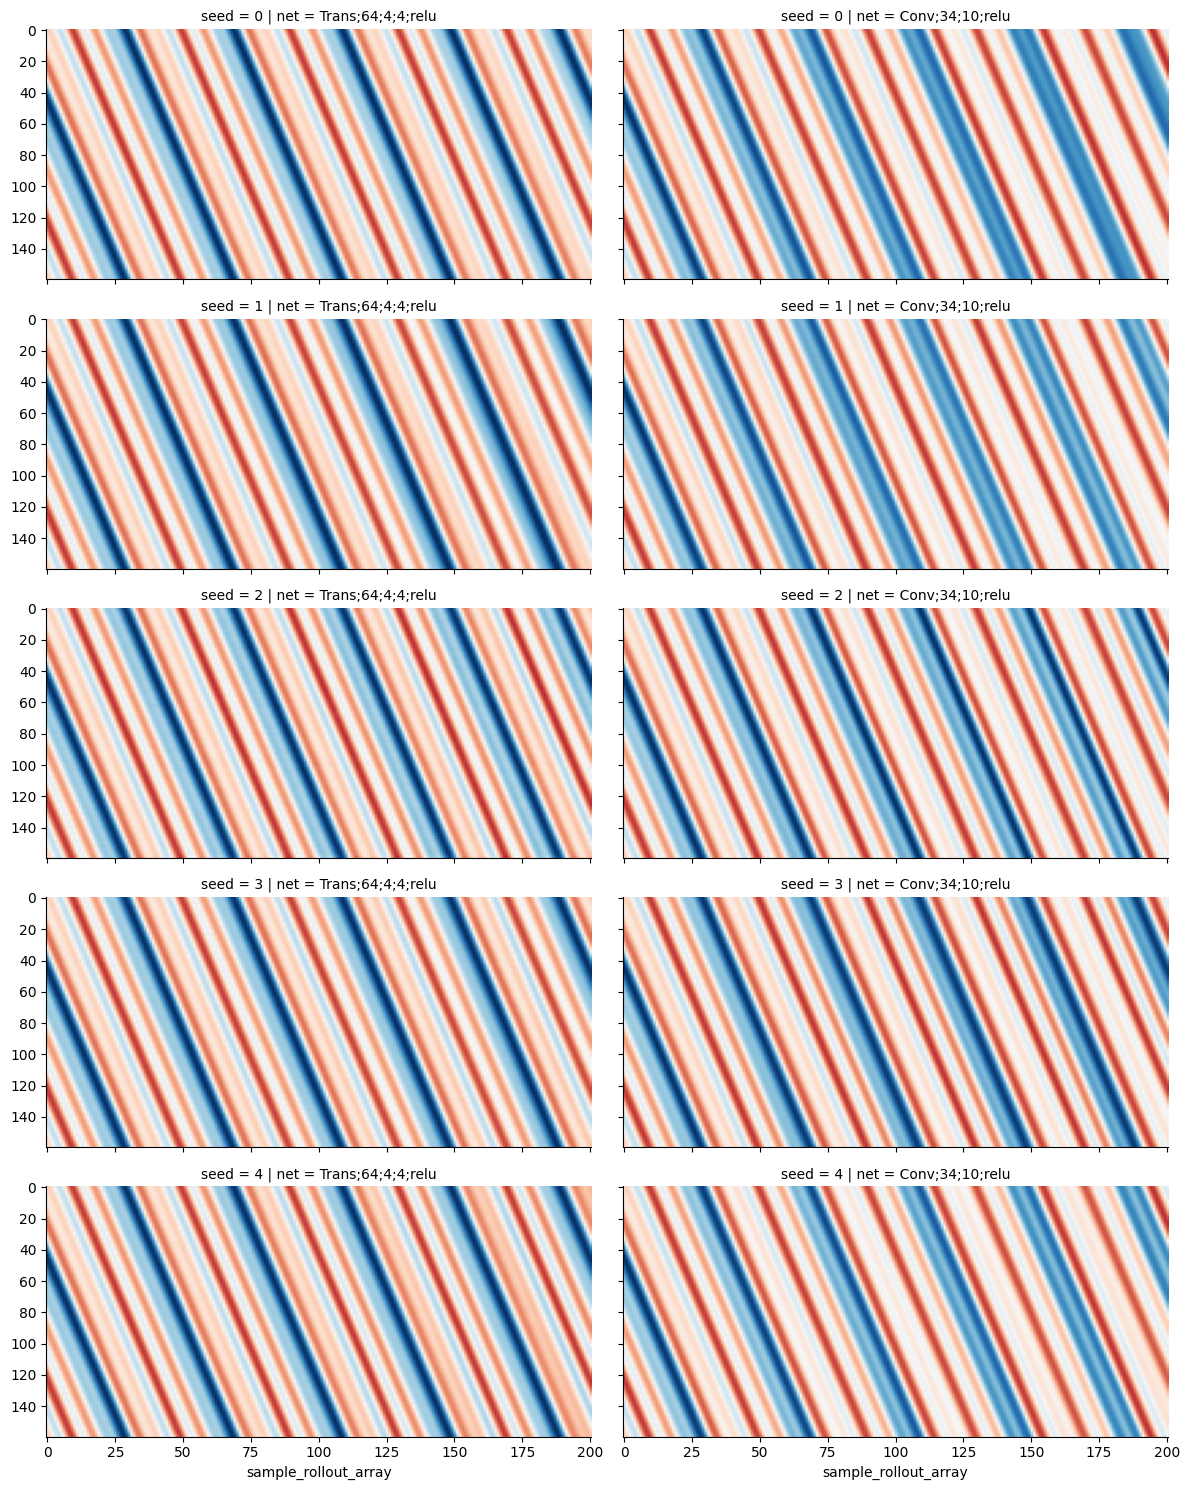

In [30]:
grid = sns.FacetGrid(sample_rollout_df, row="seed", col="net", aspect=2)
grid.map(
    lambda x, **kwargs: plt.imshow(
        x.values[0][:, 0, :].T,
        vmin=-1,
        vmax=1,
        cmap="RdBu_r",
        aspect="auto",
    ),
    "sample_rollout_array",
)

In [32]:
test_data = advection_scenario.get_test_data()
test_data.shape

(30, 201, 1, 160)

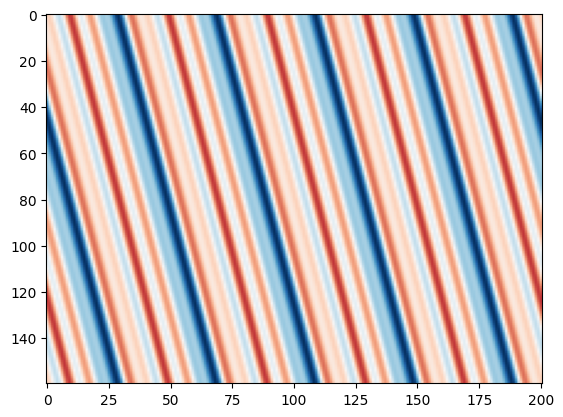

In [34]:
plt.imshow(test_data[0, :, 0, :].T, vmin=-1, vmax=1, cmap="RdBu_r", aspect="auto")